In [1]:
import torch
from torch import nn
import collections
import matplotlib.pyplot as plt
from IPython import display

#from sklearn.datasets import fetch_california_housing
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, LabelBinarizer, LabelEncoder, OneHotEncoder\
    , FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

from common.optim.meta import MetaData
from common.optim.optimise_v5 import NetLineStepProcessorMSE
from common.ffn_minst_relu import RegressionReLU, MNISTReLU

import logging

In [2]:
logging.basicConfig(filename="logs/california_housing_regression.log",
                level=logging.INFO,
                format="%(levelname)s: %(asctime)s %(message)s",
                datefmt="%m/%d/%Y %I:%M:%S")

#### Constants

In [3]:
OUTPUT_DIM=1
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

slope_plus, slope_minus=1.0, 0.0

#EXPERIMENTS = 3 #10
#EPOCHS_PER_EXPERIMENT = 30
#DATASET_PATH = "./datasets"

#### California housing dataset

In [4]:
housing = pd.read_csv("datasets_regression/housing.csv")
housing["income_cat"]=np.ceil(housing["median_income"]/1.5)
housing["income_cat"]=housing["income_cat"].apply(lambda x: 5 if x>5 else x)

split= StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_idx,test_idx in split.split(housing,housing["income_cat"]):
    strat_train_set=housing.loc[train_idx]
    strat_test_set=housing.loc[test_idx]

temp = (strat_train_set,strat_test_set)
for ii in temp:
    ii.drop(["income_cat"],axis=1,inplace=True)


In [5]:
rooms_ix,bedrooms_ix,population_ix,household_ix=3,4,5,6

class FeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self,add_bedrooms_per_room=True):
        self.add_bedrooms_per_room=add_bedrooms_per_room
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        rooms_per_household=X[:,rooms_ix]/X[:,household_ix]
        population_per_household=X[:,population_ix]/X[:,household_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room=X[:,bedrooms_ix]/X[:,rooms_ix]
            return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household,population_per_household]

num_attribs=["longitude", "latitude", "housing_median_age", "total_rooms", \
    "total_bedrooms", "population", "households", "median_income"]
cat_attribs=["ocean_proximity"]

num_pipeline=Pipeline([
    ("imputer",SimpleImputer(strategy="median")),
    ("feature_adder",FeatureAdder()),
    ("std_scaler",StandardScaler()),
])

full_pipeline=ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

#### Train set transformaion

In [6]:
Y_train=strat_train_set["median_house_value"].copy()
X_train=strat_train_set.drop("median_house_value",axis=1)
X_train_prepared = full_pipeline.fit_transform(X_train)

Y_test= strat_test_set["median_house_value"].copy()
X_test= strat_test_set.drop("median_house_value",axis=1)
X_test_prepared = full_pipeline.transform(X_test)

#### Train with linear regression, MSE value on test set is estimited

In [7]:
lin_reg=LinearRegression()
lin_reg.fit(X_train_prepared,Y_train)

lin_predictions= lin_reg.predict(X_test_prepared)
lin_rmse= np.sqrt(mean_squared_error(Y_test,lin_predictions))
print("rmse for linear regression={}".format(lin_rmse))


rmse for linear regression=66913.4419132093


#### Train with two-step algorithm

In [8]:
X_train_prepared_tn = torch.from_numpy(X_train_prepared).float().to(DEVICE)
Y_train_tn = torch.from_numpy(Y_train.to_numpy()).float().to(DEVICE)[:, None]

X_test_prepared_tn = torch.from_numpy(X_test_prepared).float().to(DEVICE)
#Y_test_tn = torch.from_numpy(Y_test.to_numpy()).float().to(DEVICE)[:, None]


In [9]:
#Weights distribution variances are set as in (5.67)
cb, cw = 0, 2.0/(slope_plus**2.0 + slope_minus**2.0)

net_regression = RegressionReLU(input_dim=16, output_dim=OUTPUT_DIM)
net_regression.set_slopes(slope_plus, slope_minus)
net_regression.init_weights(cb, cw)
net_regression.to(DEVICE)

meta = MetaData(batch_size = Y_train.size, output_dim=OUTPUT_DIM, device=DEVICE)
opt_regression = NetLineStepProcessorMSE(net_regression, nn.MSELoss(), meta, DEVICE)
opt_regression.eta0 = 0.0001
opt_regression.alpha = 1/Y_train.size
opt_regression.beta = 1e-6


In [10]:
HISTORY_PARAMS = collections.defaultdict(list)

def print_loss():
    display.clear_output()
    fig, axes = plt.subplots(1, 1, figsize=(8, 6))
    axes.set_title('Loss (MSE)')
    axes.plot(HISTORY_PARAMS['test_loss'], color='g',alpha=.5, label='Net-line two-steps')
    axes.grid()
    axes.legend()
    axes.set_xlabel("Gradient descent step")
    axes.set_ylabel("Loss value")

    plt.show()

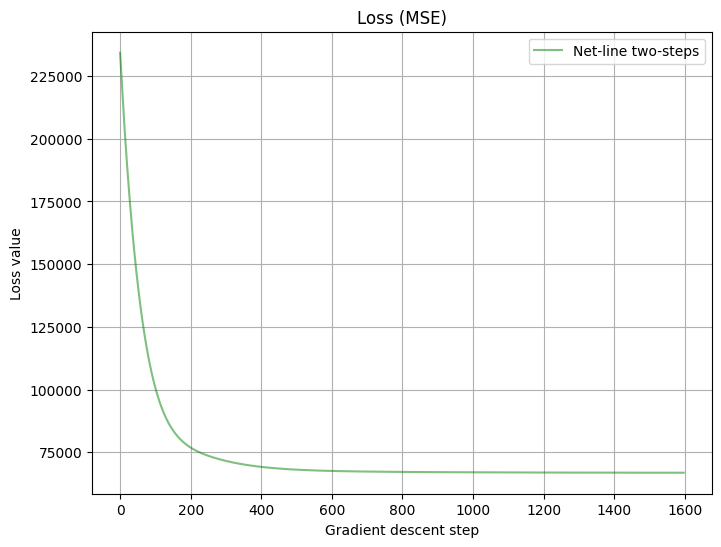

In [11]:
def rmse_validation():
    with torch.no_grad():
        net_predictions= net_regression.forward(X_test_prepared_tn)
        return np.sqrt(mean_squared_error(Y_test, torch.squeeze(net_predictions).cpu().numpy()))
        #print("rmse for linear regression={}".format(net_rmse))

rmse_prev, rmse_next = 1e10, rmse_validation() 

while (rmse_prev - rmse_next)/rmse_next > 1e-6:
    rmse_prev = rmse_next
    step_result = opt_regression.step(Y_train_tn, X_train_prepared_tn, momentum=0.0)
    rmse_next = rmse_validation()
    HISTORY_PARAMS['test_loss'].append(rmse_next)
    if len(HISTORY_PARAMS['test_loss']) % 250 == 0:
        print_loss()

print_loss()


In [12]:
print("rmse for linear regression={}".format(rmse_validation()))


rmse for linear regression=66839.84683910031
